In [ ]:
'''
Логистическая регрессия
'''

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats

%matplotlib inline

In [ ]:
# Построим сигмоиду

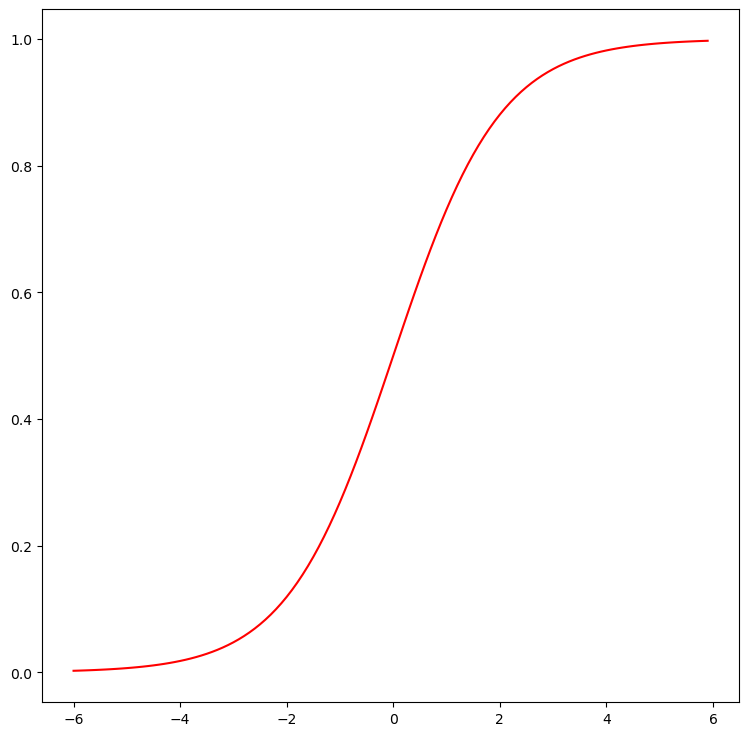

In [2]:
plt.figure(figsize=(9,9))

def sigmoid(t): 
    return (1/(1 + np.e**(-t)))    

plot_range = np.arange(-6, 6, 0.1)       

y_values = sigmoid(plot_range)

# Plot curve
plt.plot(plot_range, 
         y_values,  
         color="red");

In [3]:
titanic_train = pd.read_csv("train.csv")

char_cabin = titanic_train["Cabin"].astype(str) 

new_Cabin = np.array([cabin[0] for cabin in char_cabin])

titanic_train["Cabin"] = pd.Categorical(new_Cabin)

# Вводим медианный возраст для пассажиров с пропущенным значением
new_age_var = np.where(titanic_train["Age"].isnull(), # Проверка
                       28,                       # Если проверка верна
                       titanic_train["Age"])     # Если нет

titanic_train["Age"] = new_age_var 

new_fare_var = np.where(titanic_train["Fare"].isnull(), # Проверяем стоимость
                       50,                         # Если верна
                       titanic_train["Fare"])     # Если нет

titanic_train["Fare"] = new_fare_var 

In [4]:
from sklearn import linear_model
from sklearn import preprocessing

In [5]:
# Запускаем Label Encoder
label_encoder = preprocessing.LabelEncoder()

# Переменную пол в числовую (0/1)
encoded_sex = label_encoder.fit_transform(titanic_train["Sex"])

# Инициализируем модель  логистической регрессии
log_model = linear_model.LogisticRegression(solver = 'lbfgs')

# Тренируем модель
log_model.fit(X = pd.DataFrame(encoded_sex), 
              y = titanic_train["Survived"])

# Проверяем интерцепт
print(log_model.intercept_)

# И коэфициенты
print(log_model.coef_)

[1.01628767]
[[-2.44597988]]


In [6]:
# Предсказания. )
preds = log_model.predict_proba(X= pd.DataFrame(encoded_sex))
preds = pd.DataFrame(preds)
preds.columns = ["Death_prob", "Survival_prob"]

# Создадим таблицу спасенных по полу
pd.crosstab(titanic_train["Sex"], preds.loc[:, "Survival_prob"])

Survival_prob,0.193147,0.734249
Sex,,
female,0,314
male,577,0


In [ ]:
'''
Предварительно, 19.3% мужчин и 73.4% женщин спаслись.
Теперь усложним модель.
'''

In [7]:
# Больше переменных преобразуем в числовые
encoded_class = label_encoder.fit_transform(titanic_train["Pclass"])
encoded_cabin = label_encoder.fit_transform(titanic_train["Cabin"])

train_features = pd.DataFrame([encoded_class,
                              encoded_cabin,
                              encoded_sex,
                              titanic_train["Age"]]).T

log_model = linear_model.LogisticRegression(solver = 'lbfgs')

# Обучим модель
log_model.fit(X = train_features ,
              y = titanic_train["Survived"])

print(log_model.intercept_)

print(log_model.coef_)

[3.85818122]
[[-0.93272694 -0.09865307 -2.51826528 -0.03339524]]


In [8]:
# Создадим предикторы
preds = log_model.predict(X= train_features)

# Таблица прогнозов и актуальных данных
pd.crosstab(preds,titanic_train["Survived"])

Survived,0,1
row_0,,
0,458,89
1,91,253


In [ ]:
'''
В нижней левой ячейке указаны ложные срабатывания: люди, для которых модель предсказала выживание, 
но на самом деле не выжили. 
В верхней левой ячейке указаны истинные отрицательные результаты: 
люди правильно идентифицированы как выжившие. 
Наконец, верхняя правая ячейка показывает ложноотрицательные результаты: 
пассажиры, которых модель определила как выживших, но на самом деле выжили.
'''

In [9]:
log_model.score(X = train_features ,
                y = titanic_train["Survived"])

0.797979797979798

In [10]:
from sklearn import metrics

# Построим матрицу запутанности
metrics.confusion_matrix(y_true=titanic_train["Survived"],
                         y_pred=preds)

array([[458,  91],
       [ 89, 253]], dtype=int64)

In [12]:
# Общие показатели классrics
print(metrics.classification_report(y_true=titanic_train["Survived"],
                                    y_pred=preds))

              precision    recall  f1-score   support

           0       0.84      0.83      0.84       549
           1       0.74      0.74      0.74       342

    accuracy                           0.80       891
   macro avg       0.79      0.79      0.79       891
weighted avg       0.80      0.80      0.80       891



In [14]:
# Загрузим тестовые данные
titanic_test = pd.read_csv("test.csv") 

char_cabin = titanic_test["Cabin"].astype(str)

new_Cabin = np.array([cabin[0] for cabin in char_cabin]) 

titanic_test["Cabin"] = pd.Categorical(new_Cabin) 

new_age_var = np.where(titanic_test["Age"].isnull(), 
                       28,                       
                       titanic_test["Age"])   

titanic_test["Age"] = new_age_var 

encoded_sex = label_encoder.fit_transform(titanic_test["Sex"])
encoded_class = label_encoder.fit_transform(titanic_test["Pclass"])
encoded_cabin = label_encoder.fit_transform(titanic_test["Cabin"])

test_features = pd.DataFrame([encoded_class,
                              encoded_cabin,
                              encoded_sex,
                              titanic_test["Age"]]).T

In [15]:
# Тестовый прогноз
test_preds = log_model.predict(X=test_features)

submission = pd.DataFrame({"PassengerId":titanic_test["PassengerId"],
                           "Survived":test_preds})
# Сохраним в csv
submission.to_csv("tutorial_logreg_submission.csv", 
                  index=False)       

In [ ]:
'''
Точность регрессии стала ниже - 0,74162.
Введение дополнительных переменных не привело к повышению точности модели.
Датасет сохранен отдельно.
'''